## PINNs for Steady Cavity Problem

Solving the 2D steady diffusion equation using a Physics Informed Neural Network (PINN).  

### Governing Equations

The equations for the 2D steady Navier-Stokes problem are given by:

$$
\begin{cases}
\cancel{\frac{\partial u}{\partial t}} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)  \\
\cancel{\frac{\partial v}{\partial t}} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{cases}
$$



### Continuity Equation

The continuity equation for incompressible flow is:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

### Momentum Equations

In terms of the components, the momentum equations are:

$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} = \frac{1}{Re} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} = \frac{1}{Re} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

where \( Re \) is the Reynolds number.

### Domain

The domain for x and y is:
$$
 x \in [0,1] \quad \text{and } \quad  y \in [0,1] .
$$

### Initial and Boundary Conditions

The boundary conditions (BCs) for this problem are as follows:

- For \( u \) and \( v \):

$$
u(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
u(x, 1) = u_i \quad \text{for } x \in [0, 1] \quad (u_i \text{ is the top wall's velocity})
$$

$$
v(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
v(x, 1) = 0 \quad \text{for } x \in [0, 1]
$$

### Loss Function for PINN

In the context of a Physics Informed Neural Network (PINN), the loss function includes terms to enforce these equations and boundary conditions:

- Residuals of the Navier-Stokes equations and continuity equation.
- Boundary conditions for \( u \) and \( v \).

The loss function can be represented as:

$$
\text{Loss} = \text{Loss}{\text{equations}} + \text{Loss}{\text{boundary conditions}}
$$

Where:
- $ \text{Loss}_{\text{equations}} $ ensures that the predicted solutions satisfy the Navier-Stokes and continuity equations.
- $ \text{Loss}_{\text{boundary conditions}} $ ensures that the boundary conditions are met.


In [293]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt

class ffm(nn.Module):
    def _init_(self, in_dim, out_dim, std_dev = 10):
        super()._init_()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))

### Define PINNs network class with Fourier Feature Mapping

In [294]:
class ffm2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        super().__init__()
        
        # define the network architecture
        # network = [nn.Linear(in_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, HL_dim), activation,
        #            nn.Linear(HL_dim, out_dim)]
        network = [ffm2(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
        
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    

    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
        print(type(u))
        # u.requires_grad=True
        # v.requires_grad=True
        # p.requires_grad=True

        # compute PDE derivatives using auto grad
        # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
        p_reshaped = p.view(Nx, Ny)  # [Nx*Ny, 1] -> [Nx, Ny]

        # Calculate indices for the boundary condition range
        start_idx = int(Ny / 5)
        end_idx = int(4 * Ny / 5)
        

        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, -1], torch.ones_like(u_reshaped[:, -1]) * u_i) \
                + loss_fun(v_reshaped[:, -1], torch.zeros_like(v_reshaped[:, -1])) \
                + loss_fun(p_reshaped[-1, :], torch.zeros_like(p_reshaped[-1, :])) \
                + loss_fun(p_y[:, 0], torch.zeros_like(p_y[:, 0])) \
                + loss_fun(p_y[:, -1], torch.zeros_like(p_y[:, -1])) \
                + loss_fun(p_x[0,:], torch.zeros_like(p_x[0,:])) \
                + loss_fun(p_x[-1,:], torch.zeros_like(p_x[0,:])) \

        
                # + loss_fun(p_x[start_idx:end_idx, -1], torch.zeros_like(p_x[start_idx:end_idx, -1])) \
                # + loss_fun(u_reshaped[start_idx:end_idx, -1], torch.ones_like(u_reshaped[start_idx:end_idx, -1]) * u_i) \
        return pde_loss, bc_loss


### Define Model and Optimizer

In [295]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [296]:
# num of points in the domain
Nx, Ny = 64, 64
u_i = 5 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j
print(type(x))
print(x.shape)

<class 'torch.Tensor'>
torch.Size([64, 64])


### Training the PINNs network

In [297]:
N_epoches = 2000
loss_per_epoch = np.zeros((N_epoches,3))
for epoch in range(N_epoches):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_per_epoch[epoch,0] = eq_loss
    loss_per_epoch[epoch,1] = BC_loss
    loss_per_epoch[epoch,2] = total_loss
    print(f"epoch: {epoch}, loss: {total_loss}")


<class 'torch.Tensor'>
epoch: 0, loss: 268.8512878417969
<class 'torch.Tensor'>
epoch: 1, loss: 258.9815673828125
<class 'torch.Tensor'>
epoch: 2, loss: 249.8717041015625
<class 'torch.Tensor'>
epoch: 3, loss: 241.299560546875
<class 'torch.Tensor'>
epoch: 4, loss: 232.56556701660156
<class 'torch.Tensor'>
epoch: 5, loss: 223.5751495361328
<class 'torch.Tensor'>
epoch: 6, loss: 214.0605010986328
<class 'torch.Tensor'>
epoch: 7, loss: 203.80694580078125
<class 'torch.Tensor'>
epoch: 8, loss: 192.81625366210938
<class 'torch.Tensor'>
epoch: 9, loss: 181.13221740722656
<class 'torch.Tensor'>
epoch: 10, loss: 168.857666015625
<class 'torch.Tensor'>
epoch: 11, loss: 156.26121520996094
<class 'torch.Tensor'>
epoch: 12, loss: 143.7112274169922
<class 'torch.Tensor'>
epoch: 13, loss: 131.6068115234375
<class 'torch.Tensor'>
epoch: 14, loss: 120.34620666503906
<class 'torch.Tensor'>
epoch: 15, loss: 110.2539291381836
<class 'torch.Tensor'>
epoch: 16, loss: 101.59166717529297
<class 'torch.Tenso

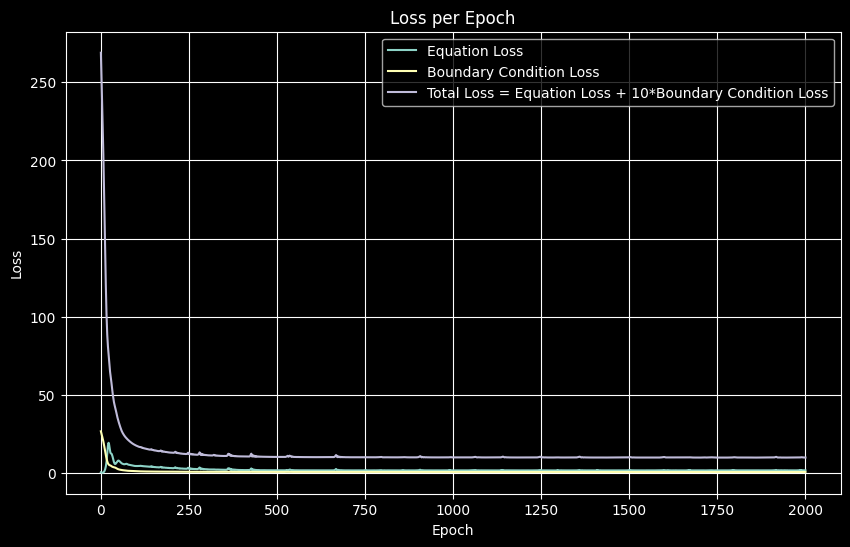

In [298]:
epocs_array = np.linspace(1,N_epoches,N_epoches)

plt.figure(figsize=(10, 6))  # Optional: specify the figure size
plt.plot(epocs_array, loss_per_epoch[:,0], '-')
plt.plot(epocs_array, loss_per_epoch[:,1], '-')
plt.plot(epocs_array, loss_per_epoch[:,2], '-')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True) 
plt.legend(['Equation Loss','Boundary Condition Loss','Total Loss = Equation Loss + 10*Boundary Condition Loss'])

# Show the plot
plt.show()

x_np:  (64, 64)
x_np:  <class 'numpy.ndarray'>
u:  torch.Size([4096])
v:  torch.Size([4096])
x_np:  (64, 64)
x_np:  <class 'numpy.ndarray'>
x:  torch.Size([64, 64])
x:  <class 'torch.Tensor'>
u:  <class 'torch.Tensor'>


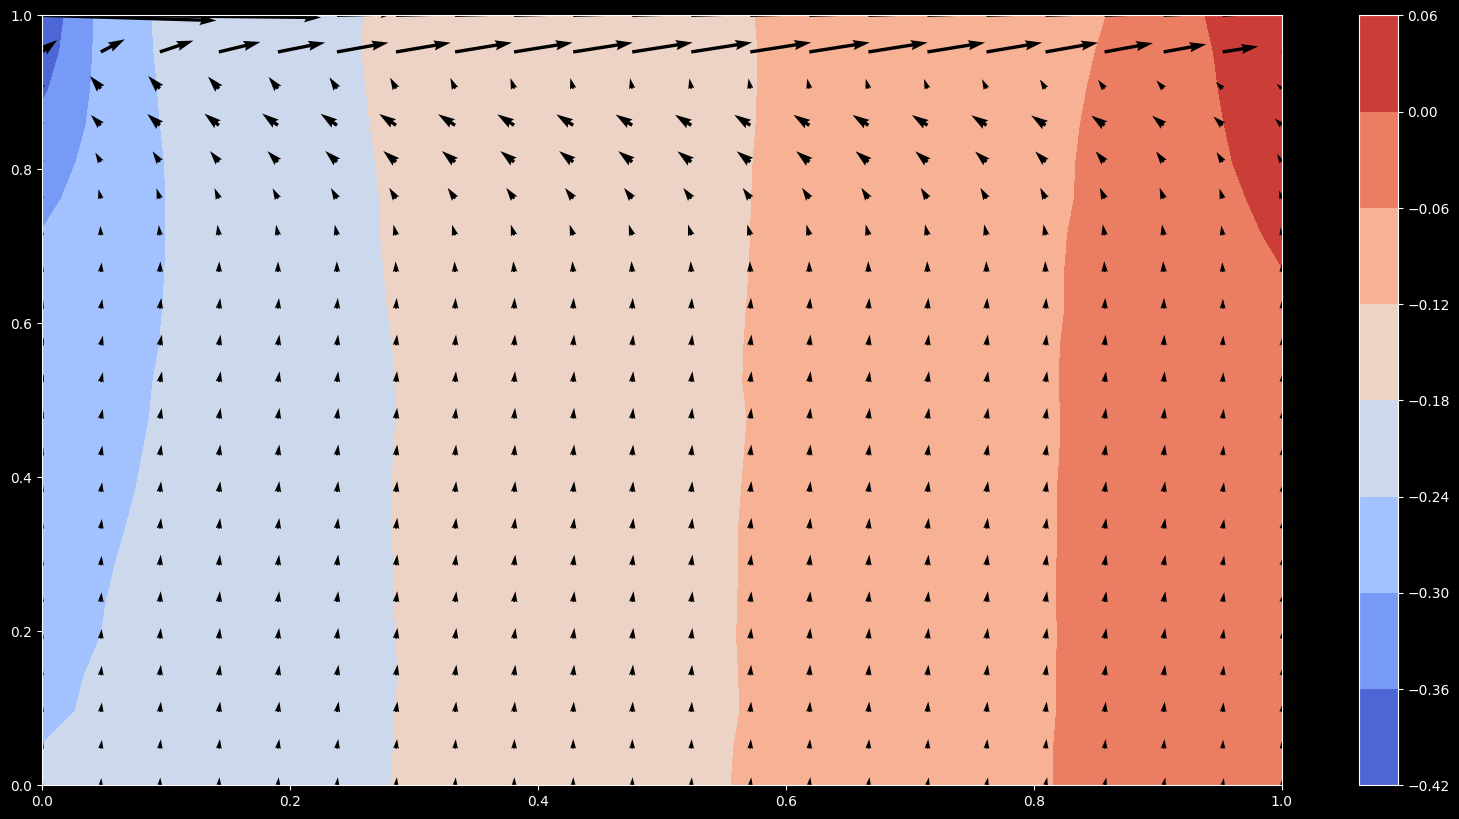

[3.5230503 3.8760028 4.193909  4.4414372 4.612792  4.723112  4.7924867
 4.837225  4.867951  4.8904867 4.9074717 4.920128  4.929596  4.9370813
 4.9431496 4.9476757 4.950739  4.9531474 4.955788  4.9588084 4.961708
 4.9640408 4.9658117 4.9671474 4.967863  4.967679  4.9665966 4.9649496
 4.963315  4.962344  4.9624195 4.9632444 4.9640517 4.964346  4.964426
 4.9650497 4.966614  4.968631  4.9701085 4.970344  4.969268  4.9671783
 4.9643717 4.9609175 4.9567056 4.951741  4.9464254 4.941515  4.937646
 4.9349346 4.932863  4.9303203 4.925703  4.9172297 4.9031925 4.8816843
 4.8495007 4.800376  4.7233033 4.6027837 4.424117  4.183978  3.8983185
 3.5963526]
max u(x=0) :  1.8533634
max v(x=0) :  0.24428901


In [299]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().numpy()
y_np = y.detach().numpy()
print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))

print("x: ",x.shape)
print("x: ",type(x))
print("u: ",type(u))

u_np = 1*u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = 1*v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
plt.contourf(x_np[::3,::3] , y_np[::3,::3], p_np[::3,::3], cmap="coolwarm")
plt.colorbar()

plt.quiver(x_np[::3,::3], y_np[::3,::3] , u_np[::3,::3] , v_np[::3,::3] , color="black", scale=25)
#plt.streamplot(x_np, y_np, u_np, v_np, color="red")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u_np[:,-1])

print("max u(x=0) : " , u_np[0,1:-1].max() )
print("max v(x=0) : " , v_np[0].max() )

In [300]:
print(BC_loss)
print(eq_loss)


tensor(0.8193, grad_fn=<AddBackward0>)
tensor(1.8496, grad_fn=<AddBackward0>)


In [301]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 